In [11]:
from model import ModelWithActivations
from torchvision.models import vgg16, squeezenet1_1
import pathlib
from tqdm import tqdm
import torch
import torch.nn as nn
import numbers
import math
import scipy.ndimage as nd
import numpy as np
from deepdream import optimize_image
import matplotlib.pyplot as plt
from PIL import Image

In [32]:
from PIL import Image
import pathlib
from torchvision import transforms
from typing import Callable
import torch.nn.functional as F
import torch
import numpy as np
from functools import partial
import matplotlib.pyplot as plt


VGG_TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        )])

def load_image(path: pathlib.Path, transform: Callable = VGG_TRANSFORM):
    img = Image.open(path)
    img = transform(img)
    img = torch.unsqueeze(img, 0) # (N, C, H, W)
    return img

In [33]:
model = ModelWithActivations(model=vgg16(pretrained=True))
image = load_image("examples/amazon.jpg")#np.random.uniform(low=0.0, high=1.0, size=(3, 100, 100)).astype(np.float32)

C:\Users\Piotr MX Labs\Desktop\nauka\deep-learning\deep-dream-experiments\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Piotr MX Labs\Desktop\nauka\deep-learning\deep-dream-experiments\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [35]:
processed_image = optimize_image(model, image.numpy().squeeze(), n_iterations=10, target_idx=71)

  0%|                                                              | 0/10 [00:00<?, ?it/s]

tensor(0.0663, grad_fn=<MeanBackward0>)


 10%|█████▍                                                | 1/10 [00:13<02:05, 13.94s/it]

tensor(0.0346, grad_fn=<MeanBackward0>)


 20%|██████████▊                                           | 2/10 [00:28<01:52, 14.07s/it]

tensor(0.0210, grad_fn=<MeanBackward0>)


 30%|████████████████▏                                     | 3/10 [00:42<01:39, 14.25s/it]

tensor(0.0030, grad_fn=<MeanBackward0>)


 40%|█████████████████████▌                                | 4/10 [00:56<01:23, 13.93s/it]

tensor(0.0954, grad_fn=<MeanBackward0>)


 50%|███████████████████████████                           | 5/10 [01:09<01:08, 13.71s/it]

tensor(0.1398, grad_fn=<MeanBackward0>)


 60%|████████████████████████████████▍                     | 6/10 [01:22<00:54, 13.61s/it]

tensor(0.3751, grad_fn=<MeanBackward0>)


 70%|█████████████████████████████████████▊                | 7/10 [01:36<00:40, 13.56s/it]

tensor(0.5233, grad_fn=<MeanBackward0>)


 80%|███████████████████████████████████████████▏          | 8/10 [01:49<00:26, 13.44s/it]

tensor(0.9769, grad_fn=<MeanBackward0>)


 90%|████████████████████████████████████████████████▌     | 9/10 [02:02<00:13, 13.40s/it]

tensor(1.5097, grad_fn=<MeanBackward0>)


100%|█████████████████████████████████████████████████████| 10/10 [02:16<00:00, 13.60s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


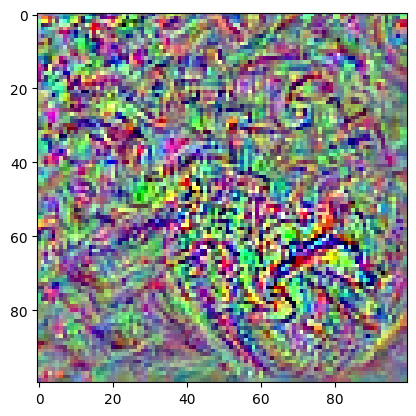

In [31]:
plt.imshow(processed_image.T)

In [5]:
model

ModelWithActivations(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)